In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [4]:
# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/RealWaste'

In [77]:
# Initialize statistics
class_counts = {}
image_dimensions = []

# Iterate over each class directory
for class_dir in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, class_dir)):
        continue
    class_counts[class_dir] = 0
    for image_name in os.listdir(os.path.join(data_path, class_dir)):
        image_path = os.path.join(data_path, class_dir, image_name)
        with Image.open(image_path) as img:
            image_dimensions.append(img.size)
        class_counts[class_dir] += 1

# Calculate summary statistics
total_images = sum(class_counts.values())
min_dim = min(image_dimensions)
max_dim = max(image_dimensions)
mean_dim = np.mean(image_dimensions, axis=0).astype(int)
std_dev_dim = np.std(image_dimensions, axis=0).astype(int)

# Display the statistics
print(f"Total number of classes: {len(class_counts)}")
print(f"Total number of images: {total_images}")
print(f"Number of images per class: {class_counts}")
print(f"Image dimensions (WxH): Min {min_dim}, Max {max_dim}, Mean {mean_dim}, Std Dev {std_dev_dim}")


Total number of classes: 9
Total number of images: 4782
Number of images per class: {'Paper': 510, 'Cardboard': 461, 'Miscellaneous Trash': 495, 'Textile Trash': 318, 'Metal': 810, 'Vegetation': 436, 'Plastic': 921, 'Glass': 420, 'Food Organics': 411}
Image dimensions (WxH): Min (524, 524), Max (524, 524), Mean [524 524], Std Dev [0 0]


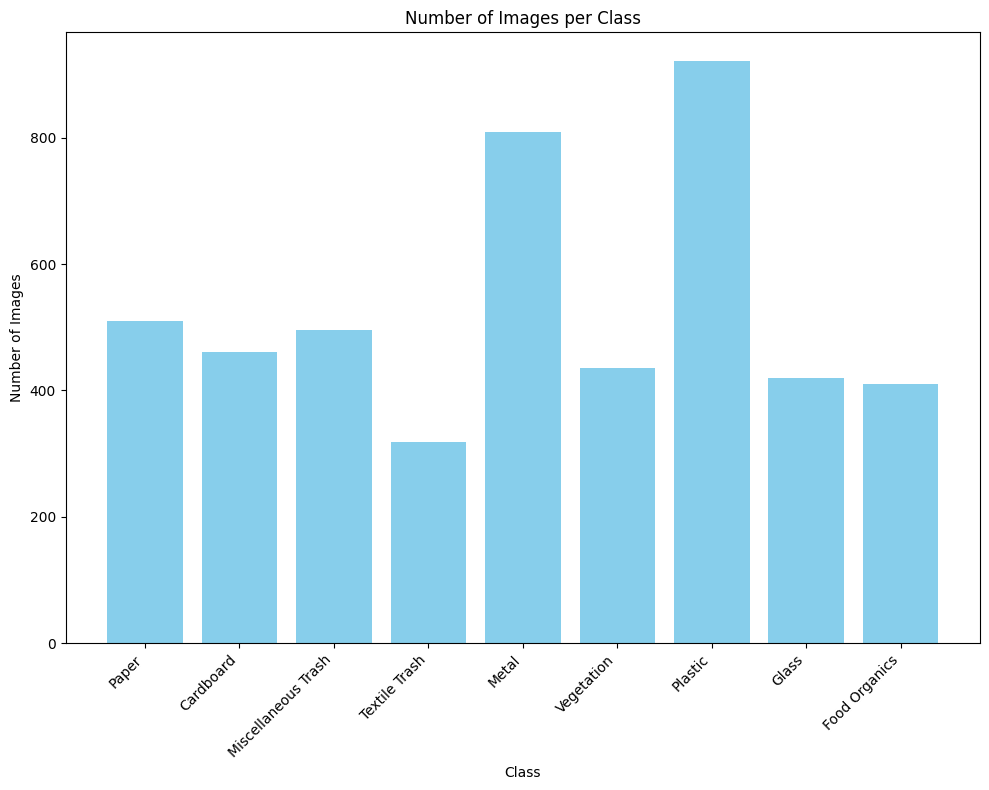

In [78]:

class_image_counts = {'Paper': 510, 'Cardboard': 461, 'Miscellaneous Trash': 495, 'Textile Trash': 318, 'Metal': 810, 'Vegetation': 436, 'Plastic': 921, 'Glass': 420, 'Food Organics': 411}

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(class_image_counts.keys(), class_image_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha="right")
plt.title('Number of Images per Class')
plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()


In [95]:
def create_stratified_splits(data_path, subset_size=0.5, train_size=0.6, val_size=0.2):
    """
    Create stratified train, validation, and test splits ensuring all classes are represented,
    excluding any existing 'train', 'val', and 'test' directories.
    """

    # Define directories for splits and original class folders
    split_dirs = ['train', 'val', 'test']
    original_classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and d not in split_dirs]

    # Iterate through each original class directory to split the files
    for class_name in original_classes:
        class_dir = os.path.join(data_path, class_name)
        files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        np.random.shuffle(files)  # Shuffle files to randomize selection

        # Calculate subset size and ensure at least one sample
        subset_size_num = max(int(len(files) * subset_size), 1)
        files_subset = files[:subset_size_num]

        # Split subset into train, val, and test
        num_train = int(len(files_subset) * train_size)
        num_val = int(len(files_subset) * val_size)
        train_files = files_subset[:num_train]
        val_files = files_subset[num_train:num_train + num_val]
        test_files = files_subset[num_train + num_val:]

        # Define function to copy files to new split folders
        def copy_files(split_name, files_list):
            split_path = os.path.join(data_path, split_name, class_name)
            os.makedirs(split_path, exist_ok=True)
            for f in files_list:
                shutil.copy(os.path.join(class_dir, f), os.path.join(split_path, f))

        # Copy the files into their respective directories
        copy_files('train', train_files)
        copy_files('val', val_files)
        copy_files('test', test_files)
        print(f"Processed {class_name}: Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}.")


In [96]:
create_stratified_splits(data_path, subset_size=0.5, train_size=0.6, val_size=0.2)

Processed Paper: Train: 153, Val: 51, Test: 51.
Processed Cardboard: Train: 138, Val: 46, Test: 46.
Processed Miscellaneous Trash: Train: 148, Val: 49, Test: 50.
Processed Textile Trash: Train: 95, Val: 31, Test: 33.
Processed Metal: Train: 243, Val: 81, Test: 81.
Processed Vegetation: Train: 130, Val: 43, Test: 45.
Processed Plastic: Train: 276, Val: 92, Test: 92.
Processed Glass: Train: 126, Val: 42, Test: 42.
Processed Food Organics: Train: 123, Val: 41, Test: 41.


In [ ]:
## only to be run to put images back to original folders from train and test


# # The original class directories are assumed to be at the same level as 'train' and 'test'
# classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d)) and d not in ['train', 'test']]

# # Move files back to their original class folders
# for class_name in classes:
#     # Define paths for train and test folders for this class
#     train_class_path = os.path.join(data_path, 'train', class_name)
#     test_class_path = os.path.join(data_path, 'test', class_name)
#     original_class_path = os.path.join(data_path, class_name)

#     # Move files from train folder back to the original class folder
#     if os.path.exists(train_class_path):
#         for file_name in os.listdir(train_class_path):
#             shutil.move(os.path.join(train_class_path, file_name), os.path.join(original_class_path, file_name))

#     # Move files from test folder back to the original class folder
#     if os.path.exists(test_class_path):
#         for file_name in os.listdir(test_class_path):
#             shutil.move(os.path.join(test_class_path, file_name), os.path.join(original_class_path, file_name))

In [5]:
train_dir = '/content/drive/MyDrive/RealWaste/train'
val_dir = '/content/drive/MyDrive/RealWaste/val'
test_dir = '/content/drive/MyDrive/RealWaste/test'

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
# Parameters
num_classes = 9
batch_size_vgg = 4
learning_rate_vgg = 1e-5

In [42]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(224, 224),  # Adjusted for VGG16 default input size
batch_size=batch_size_vgg,
class_mode='categorical'
)

Found 1432 images belonging to 9 classes.


In [43]:
val_generator = val_datagen.flow_from_directory(
   val_dir,
    target_size=(224, 224),
    batch_size=batch_size_vgg,  # Adjusted batch size
    class_mode='categorical'
)

Found 476 images belonging to 9 classes.


In [44]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjusted for VGG16 default input size
    batch_size=batch_size_vgg,  # Adjusted batch size
    class_mode='categorical'
)

Found 481 images belonging to 9 classes.


In [11]:
# Build the VGG16 model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False



58889256/58889256 [==============================] - 2s 0us/step


In [12]:
model_0 = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])



In [34]:
model_0.compile(optimizer=Adam(learning_rate=learning_rate_vgg), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_0.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)



Epoch 1/30
358/358 [==============================] - 276s 769ms/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.8188 - val_accuracy: 0.7311
Epoch 2/30
358/358 [==============================] - 18s 50ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.8160 - val_accuracy: 0.7269
Epoch 3/30
358/358 [==============================] - 18s 51ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.8250 - val_accuracy: 0.7269
Epoch 4/30
358/358 [==============================] - 18s 49ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.8273 - val_accuracy: 0.7311
Epoch 5/30
358/358 [==============================] - 18s 51ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.8276 - val_accuracy: 0.7290
Epoch 6/30
358/358 [==============================] - 18s 50ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.8540 - val_accuracy: 0.7311
Epoch 7/30
358/358 [==============================] - 18s 50ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.8561 - val_accurac

In [35]:
# Save the model to Google Drive
model_0.save('/content/drive/My Drive/Models/vgg16_waste_classifier_model0.keras')

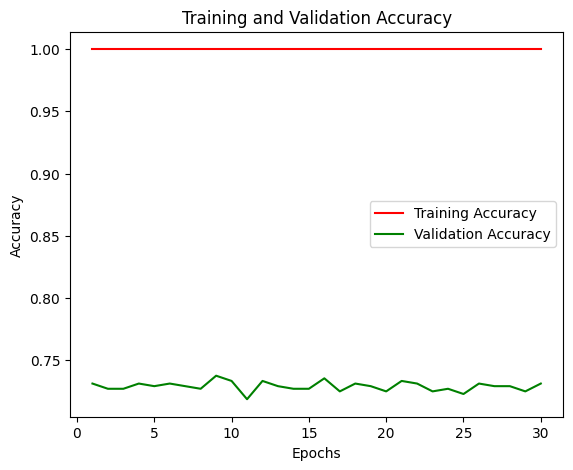

In [36]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()


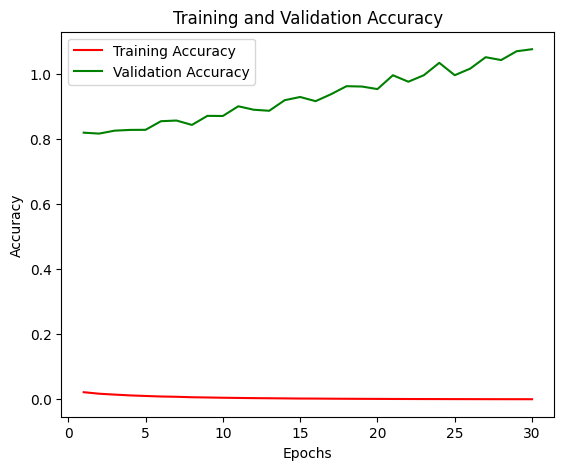

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, loss, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_loss, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

In [38]:
# Evaluating the Model
test_loss, test_accuracy = model_0.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


120/120 [==============================] - 5s 42ms/step - loss: 1.0213 - accuracy: 0.7354
Test loss: 1.0213245153427124
Test accuracy: 0.7354166507720947


## Building a DenseNet Model

In [39]:
from tensorflow.keras.applications import DenseNet121

# Parameters
batch_size_dense = 16
learning_rate_dense = 1e-4



In [40]:
# DenseNet121 Model
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_dense.trainable = False  # Freeze the convolutional base
model_1 = Sequential([
    base_model_dense,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])



In [41]:
# Compile DenseNet121 Model
model_1.compile(optimizer=Adam(learning_rate=learning_rate_dense),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])



In [42]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/30
358/358 [==============================] - 29s 60ms/step - loss: 2.2198 - accuracy: 0.2039 - val_loss: 1.9392 - val_accuracy: 0.3067
Epoch 2/30
358/358 [==============================] - 20s 55ms/step - loss: 1.7374 - accuracy: 0.3687 - val_loss: 1.6235 - val_accuracy: 0.4265
Epoch 3/30
358/358 [==============================] - 21s 57ms/step - loss: 1.4709 - accuracy: 0.4930 - val_loss: 1.4268 - val_accuracy: 0.5168
Epoch 4/30
358/358 [==============================] - 20s 56ms/step - loss: 1.2907 - accuracy: 0.5524 - val_loss: 1.2890 - val_accuracy: 0.5651
Epoch 5/30
358/358 [==============================] - 20s 57ms/step - loss: 1.1692 - accuracy: 0.6075 - val_loss: 1.1878 - val_accuracy: 0.6050
Epoch 6/30
358/358 [==============================] - 19s 53ms/step - loss: 1.0713 - accuracy: 0.6411 - val_loss: 1.1120 - val_accuracy: 0.6513
Epoch 7/30
358/358 [==============================] - 20s 57ms/step - loss: 0.9966 - accuracy: 0.6746 - val_loss: 1.0553 - val_accuracy:

In [43]:
# Save the model to Google Drive
model_1.save('/content/drive/My Drive/Models/densenet_waste_classifier_model1.keras')

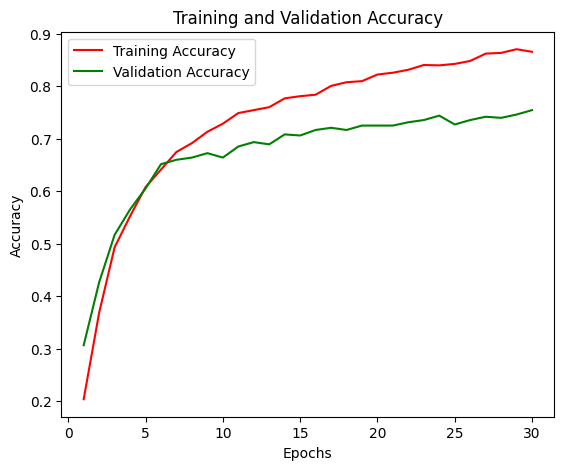

In [44]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

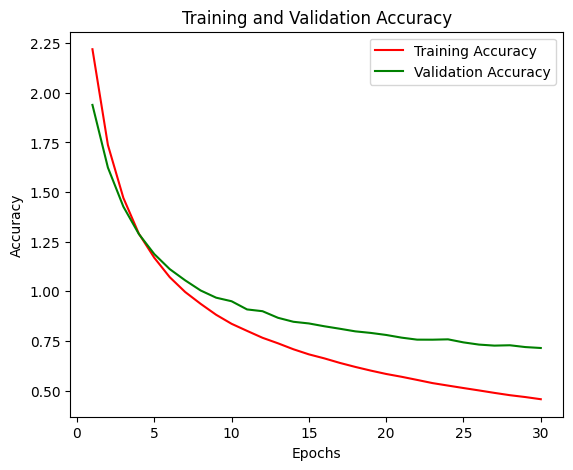

In [45]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, loss, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_loss, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

In [46]:
# Evaluating the Model
test_loss, test_accuracy = model_1.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


120/120 [==============================] - 5s 38ms/step - loss: 0.7705 - accuracy: 0.7021
Test loss: 0.7704894542694092
Test accuracy: 0.7020833492279053


## Building an Inception V3 Model

In [56]:
from tensorflow.keras import backend as K
K.clear_session()



In [6]:
from tensorflow.keras.applications import InceptionV3

# Parameters
batch_size_inception = 32  # From the table
learning_rate_inception = 1e-5  # From the table

In [7]:
# Data Generators for InceptionV3
train_datagen_inception = ImageDataGenerator(rescale=1./255)
validation_datagen_inception = ImageDataGenerator(rescale=1./255)
test_datagen_inception = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator_inception = train_datagen_inception.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size_inception,
    class_mode='categorical')

Found 1432 images belonging to 9 classes.


In [9]:
validation_generator_inception = validation_datagen_inception.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=batch_size_inception,
    class_mode='categorical')

Found 476 images belonging to 9 classes.


In [10]:
test_generator_inception = test_datagen_inception.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size_inception,
    class_mode='categorical')

Found 481 images belonging to 9 classes.


In [12]:
# InceptionV3 Model
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_inception.trainable = False  # Freeze the convolutional base
model_2 = Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')
])

In [13]:
# Compile InceptionV3 Model
model_2.compile(optimizer=Adam(learning_rate=learning_rate_inception),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [14]:
# Train the model
history_2 = model_2.fit(
    train_generator_inception,
    steps_per_epoch=train_generator_inception.samples // train_generator_inception.batch_size,
    epochs=30,
    validation_data=validation_generator_inception,
    validation_steps=validation_generator_inception.samples // validation_generator_inception.batch_size
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 964ms/step - accuracy: 0.1038 - loss: 2.3731 - val_accuracy: 0.1518 - val_loss: 2.2050
Epoch 2/30
 1/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.1250 - loss: 2.1676

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 753ms/step - accuracy: 0.1250 - loss: 2.1676 - val_accuracy: 0.0357 - val_loss: 2.2089
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 71s 393ms/step - accuracy: 0.1623 - loss: 2.1583 - val_accuracy: 0.1942 - val_loss: 2.1025
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1562 - loss: 2.0773 - val_accuracy: 0.1786 - val_loss: 2.0953
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.2190 - loss: 2.0581 - val_accuracy: 0.2455 - val_loss: 2.0126
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.2500 - loss: 1.9579 - val_accuracy: 0.1786 - val_loss: 2.0575
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 435ms/step - accuracy: 0.2943 - loss: 1.9576 - val_accuracy: 0.2946 - val_loss: 1.9382
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3438 - loss: 1.9820 - val_accuracy: 0.2500 - val_loss: 1.8245
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - accuracy: 0.3382 - loss: 1.8791 - val_accuracy: 0.3728 - val_

In [15]:
# Save the model to Google Drive
model_2.save('/content/drive/My Drive/Models/inception_waste_classifier_model2.keras')

In [31]:
# Evaluating the Model
test_loss, test_accuracy = model_2.evaluate(test_generator_inception, steps=test_generator_inception.samples // test_generator_inception.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.5907 - loss: 1.3066
Test loss: 1.3223893642425537
Test accuracy: 0.5916666388511658


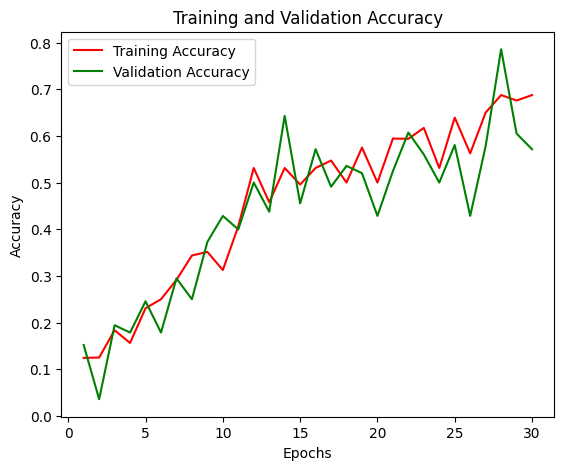

In [16]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

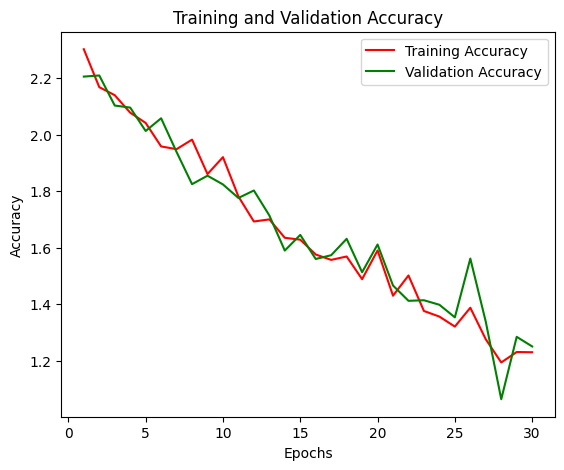

In [17]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, loss, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_loss, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

## Building Inception ResNet V2 Model

In [18]:
from tensorflow.keras.applications import InceptionResNetV2

# Parameters
batch_size_inceptionresnet = 32
learning_rate_inceptionresnet = 1e-6

In [20]:
# InceptionResNetV2 Model
base_model_inceptionresnet = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model_inceptionresnet.trainable = False  # Freeze the convolutional base
model_3 = Sequential([
    base_model_inceptionresnet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')
])

In [21]:
# Compile InceptionResNetV2 Model
model_3.compile(optimizer=Adam(learning_rate=learning_rate_inceptionresnet),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

In [22]:
# Data Generators for InceptionResNetV2
train_datagen_inceptionresnet = ImageDataGenerator(rescale=1./255)
validation_datagen_inceptionresnet = ImageDataGenerator(rescale=1./255)
test_datagen_inceptionresnet = ImageDataGenerator(rescale=1./255)

In [23]:
train_generator_inceptionresnet = train_datagen_inceptionresnet.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size_inceptionresnet,
    class_mode='categorical')

Found 1432 images belonging to 9 classes.


In [24]:
validation_generator_inceptionresnet = validation_datagen_inceptionresnet.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=batch_size_inceptionresnet,
    class_mode='categorical')

Found 476 images belonging to 9 classes.


In [25]:
test_generator_inceptionresnet = test_datagen_inceptionresnet.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size_inceptionresnet,
    class_mode='categorical')

Found 481 images belonging to 9 classes.


In [26]:
# Train the model
history_3 = model_3.fit(
    train_generator_inception,
    steps_per_epoch=train_generator_inceptionresnet.samples // train_generator_inceptionresnet.batch_size,
    epochs=30,
    validation_data=validation_generator_inceptionresnet,
    validation_steps=validation_generator_inceptionresnet.samples // validation_generator_inceptionresnet.batch_size
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.1664 - loss: 2.2015

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1665 - loss: 2.2012 - val_accuracy: 0.1942 - val_loss: 2.1651
Epoch 2/30
 1/44 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.1250 - loss: 2.2733

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.1250 - loss: 2.2733 - val_accuracy: 0.0714 - val_loss: 2.4301
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.1788 - loss: 2.1802 - val_accuracy: 0.1897 - val_loss: 2.1648
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0938 - loss: 2.3342 - val_accuracy: 0.2857 - val_loss: 2.1669
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 650ms/step - accuracy: 0.1728 - loss: 2.1833 - val_accuracy: 0.1942 - val_loss: 2.1492
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.1875 - loss: 2.2443 - val_accuracy: 0.2143 - val_loss: 2.1701
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 597ms/step - accuracy: 0.2004 - loss: 2.1526 - val_accuracy: 0.1987 - val_loss: 2.1285
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - accuracy: 0.2500 - loss: 2.2203 - val_accuracy: 0.1429 - val_loss: 2.2704
Epoch 9/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - accuracy: 0.1999 - loss: 2.1376 - val_accuracy: 0.2098 - v

In [27]:
# Save the model to Google Drive
model_3.save('/content/drive/My Drive/Models/inceptionresnet_waste_classifier_model3.keras')

In [28]:
# Evaluating the Model
test_loss, test_accuracy = model_3.evaluate(test_generator_inceptionresnet, steps=test_generator_inceptionresnet.samples // test_generator_inceptionresnet.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.2786 - loss: 1.9899
Test loss: 2.014899730682373
Test accuracy: 0.27291667461395264


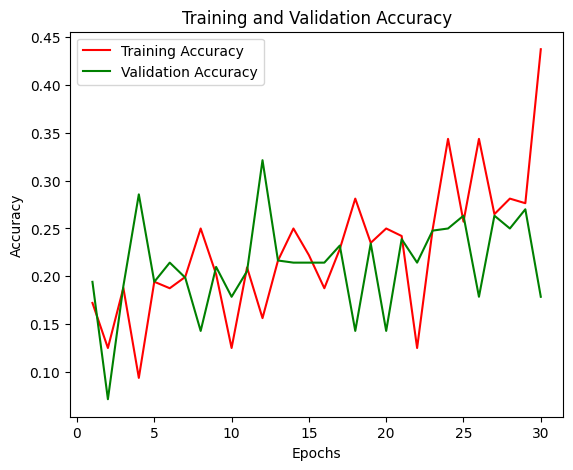

In [29]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

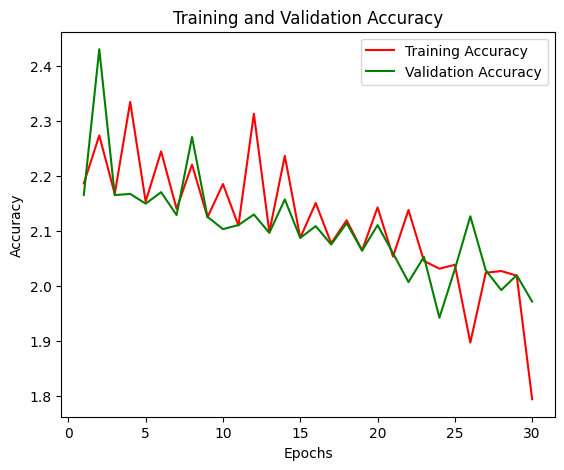

In [30]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, loss, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_loss, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

## Building MobileNetV2 Model

In [32]:
from tensorflow.keras.applications import MobileNetV2

# Parameters
batch_size_mobilenet = 4
learning_rate_mobilenet = 1e-5

In [34]:
# MobileNetV2 Model
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False  # Freeze the convolutional base
model_4 = Sequential([
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')
])

In [35]:
# Compile MobileNetV2 Model
model_4.compile(optimizer=Adam(learning_rate=learning_rate_mobilenet),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [45]:
# Train the model
history_4 = model_4.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/358 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.1296 - loss: 2.3593 - val_accuracy: 0.2395 - val_loss: 1.9978
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


358/358 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3250 - loss: 1.9109 - val_accuracy: 0.4055 - val_loss: 1.7228
Epoch 4/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 49us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.4411 - loss: 1.6410 - val_accuracy: 0.4979 - val_loss: 1.5231
Epoch 6/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.5405 - loss: 1.4368 - val_accuracy: 0.5504 - val_loss: 1.3732
Epoch 8/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/30
358/358 ━━━━━━━━━━━━━━━━━━━━ 27s 

In [46]:
# Save the model to Google Drive
model_4.save('/content/drive/My Drive/Models/mobilenet_waste_classifier_model4.keras')

In [47]:
# Evaluating the Model
test_loss, test_accuracy = model_4.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

  3/120 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8611 - loss: 0.4965  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7180 - loss: 0.8614
Test loss: 0.9173755049705505
Test accuracy: 0.6791666746139526


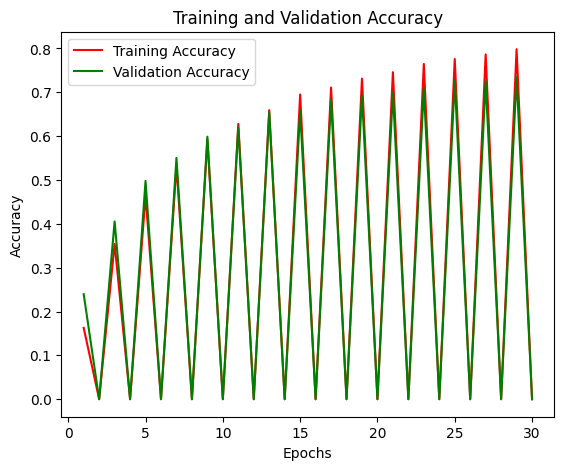

In [48]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

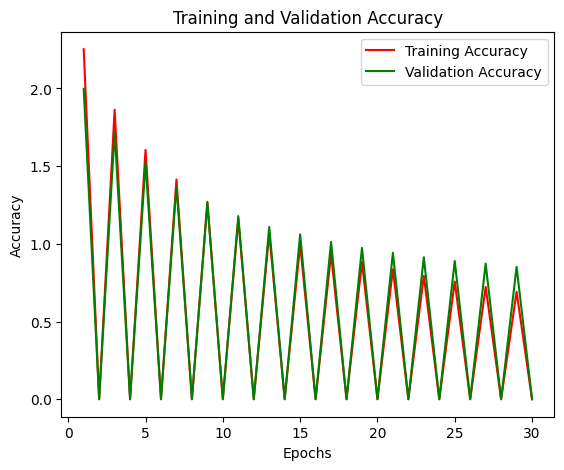

In [49]:
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, loss, 'r-', label='Training Accuracy')  # 'r-' for solid red line
plt.plot(epochs, val_loss, 'g-', label='Validation Accuracy')  # 'g-' for solid green line
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Add your plotting for loss here if needed

plt.show()

## Model with dense layer learning rate = 0.00001 and batch size = 4

In [16]:
model_1 = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [17]:
model_1.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

Found 1432 images belonging to 9 classes.


In [19]:
val_generator = val_datagen.flow_from_directory(
   val_dir,
    target_size=(224, 224),
    batch_size=4,  # Adjusted batch size
    class_mode='categorical'
)

Found 476 images belonging to 9 classes.


In [20]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjusted for VGG16 default input size
    batch_size=4,  # Adjusted batch size
    class_mode='categorical'
)

Found 481 images belonging to 9 classes.


In [21]:
history = model_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust based on your needs
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/50
358/358 [==============================] - 157s 432ms/step - loss: 1.7992 - accuracy: 0.3687 - val_loss: 1.5022 - val_accuracy: 0.4832
Epoch 2/50
358/358 [==============================] - 17s 48ms/step - loss: 1.2681 - accuracy: 0.5957 - val_loss: 1.2283 - val_accuracy: 0.5987
Epoch 3/50
358/358 [==============================] - 17s 49ms/step - loss: 1.0210 - accuracy: 0.6892 - val_loss: 1.1116 - val_accuracy: 0.6239
Epoch 4/50
358/358 [==============================] - 17s 47ms/step - loss: 0.8434 - accuracy: 0.7570 - val_loss: 1.0085 - val_accuracy: 0.6660
Epoch 5/50
358/358 [==============================] - 17s 48ms/step - loss: 0.7106 - accuracy: 0.8205 - val_loss: 0.9606 - val_accuracy: 0.7038
Epoch 6/50
358/358 [==============================] - 18s 50ms/step - loss: 0.6055 - accuracy: 0.8506 - val_loss: 0.9680 - val_accuracy: 0.6450
Epoch 7/50
358/358 [==============================] - 18s 50ms/step - loss: 0.5290 - accuracy: 0.8848 - val_loss: 0.8948 - val_accurac

In [24]:
# Save the model to Google Drive
model_1.save('/content/drive/My Drive/Models/vgg16_waste_classifier_model1.keras')

In [25]:
# Evaluating the Model
test_loss, test_accuracy = model_1.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


120/120 [==============================] - 5s 37ms/step - loss: 0.9135 - accuracy: 0.7375
Test loss: 0.9135069251060486
Test accuracy: 0.737500011920929


## Building a model by unfreezing a few layers

In [27]:
model_2 = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')])

In [28]:
n = 4  # Number of layers to unfreeze
for layer in vgg16_base.layers[-n:]:
    layer.trainable = True

model_2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model_2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [31]:
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/50
358/358 [==============================] - 17s 48ms/step - loss: 1.5754 - accuracy: 0.4763 - val_loss: 1.3468 - val_accuracy: 0.5567
Epoch 2/50
358/358 [==============================] - 17s 48ms/step - loss: 1.1506 - accuracy: 0.6508 - val_loss: 1.1644 - val_accuracy: 0.6134
Epoch 3/50
358/358 [==============================] - 17s 48ms/step - loss: 0.9272 - accuracy: 0.7284 - val_loss: 1.0385 - val_accuracy: 0.6534
Epoch 4/50
358/358 [==============================] - 17s 47ms/step - loss: 0.7738 - accuracy: 0.7877 - val_loss: 0.9829 - val_accuracy: 0.6744
Epoch 5/50
358/358 [==============================] - 17s 47ms/step - loss: 0.6473 - accuracy: 0.8338 - val_loss: 0.9069 - val_accuracy: 0.6996
Epoch 6/50
358/358 [==============================] - 16s 46ms/step - loss: 0.5489 - accuracy: 0.8687 - val_loss: 0.8774 - val_accuracy: 0.6996
Epoch 7/50
358/358 [==============================] - 19s 52ms/step - loss: 0.4741 - accuracy: 0.9015 - val_loss: 0.8688 - val_accuracy:

In [32]:
# Save the model to Google Drive
model_2.save('/content/drive/My Drive/Models/vgg16_waste_classifier_model2.keras')

In [33]:
# Evaluating the Model
test_loss, test_accuracy = model_2.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


120/120 [==============================] - 4s 34ms/step - loss: 0.9108 - accuracy: 0.7312
Test loss: 0.9107628464698792
Test accuracy: 0.731249988079071


In [11]:
# Parameters
num_classes = 9
batch_size = 4
epochs = 30

# Define your parameter grid
param_grid = {
    'rotation_range': [20],  # Experiment with more values as needed
    'width_shift_range': [0.1, 0.2],  # Experiment with more values as needed
    'height_shift_range': [0.1, 0.2],  # Experiment with more values as needed
    'shear_range': [0.0, 0.2],
    'horizontal_flip': [True, False]
}

# Initialize a dictionary to store the results
results = []

# Set up the base VGG16 model
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Val data generator (without augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Iterate through all combinations of parameters
grid = list(ParameterGrid(param_grid))
for params in grid:
    print(f"Training with parameters: {params}")

    # Set up the training data generator
    train_datagen = ImageDataGenerator(rescale=1./255, **params)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Build and compile the model
    model = build_model()

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size
    )

 # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Finished training with parameters: {params}")
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # Store the results
    results.append({'params': params, 'test_loss': test_loss, 'test_accuracy': test_accuracy})

# Find the best parameters
best_params = max(results, key=lambda x: x['test_accuracy'])
print(f"Best parameters: {best_params['params']}")
print(f"Test Loss: {best_params['test_loss']}, Test Accuracy: {best_params['test_accuracy']}")




Found 476 images belonging to 9 classes.
Found 481 images belonging to 9 classes.
Training with parameters: {'height_shift_range': 0.1, 'horizontal_flip': True, 'rotation_range': 20, 'shear_range': 0.0, 'width_shift_range': 0.1}
Found 1432 images belonging to 9 classes.
Epoch 1/30
358/358 [==============================] - 41s 110ms/step - loss: 1.8413 - accuracy: 0.3485 - val_loss: 1.5505 - val_accuracy: 0.4622
Epoch 2/30
358/358 [==============================] - 32s 90ms/step - loss: 1.4396 - accuracy: 0.5196 - val_loss: 1.3254 - val_accuracy: 0.5399
Epoch 3/30
358/358 [==============================] - 32s 88ms/step - loss: 1.2566 - accuracy: 0.5740 - val_loss: 1.1812 - val_accuracy: 0.5756
Epoch 4/30
358/358 [==============================] - 32s 89ms/step - loss: 1.1181 - accuracy: 0.6292 - val_loss: 1.0992 - val_accuracy: 0.6092
Epoch 5/30
358/358 [==============================] - 32s 91ms/step - loss: 1.0348 - accuracy: 0.6578 - val_loss: 1.0404 - val_accuracy: 0.6618
Epoch 6/

In [8]:
from PIL import Image

# Replace 'path_to_your_image.jpg' with the actual path to your image
image_path = '/content/drive/MyDrive/RealWaste/train/Cardboard/Cardboard_100.jpg'

# Open the image
img = Image.open(image_path)

# Get the size of the image
width, height = img.size

# Print the size
print(f'The image size is {width}x{height} pixels')


The image size is 524x524 pixels


## DenseNet

In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
# Set the paths to your dataset
train_dir = '/content/drive/MyDrive/RealWaste/train'
test_dir = '/content/drive/MyDrive/RealWaste/test'

In [10]:
# Define the parameters for the data generators
img_size = (224, 224)  # DenseNet default image size
batch_size = 32

In [11]:
# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [12]:

test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 1787 images belonging to 9 classes.


In [14]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 839 images belonging to 9 classes.


In [7]:
# Number of classes
num_classes = len(train_generator.class_indices)

NameError: name 'train_generator' is not defined

In [18]:
# Build the DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))

29084464/29084464 [==============================] - 0s 0us/step


In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
# Freeze the layers except the last ones
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,  # Number of epochs to train for
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

Epoch 1/50
55/55 [==============================] - 38s 688ms/step - loss: 0.1530 - accuracy: 0.9493 - val_loss: 0.5623 - val_accuracy: 0.8281
Epoch 2/50
55/55 [==============================] - 38s 694ms/step - loss: 0.1143 - accuracy: 0.9664 - val_loss: 0.6092 - val_accuracy: 0.8173
Epoch 3/50
55/55 [==============================] - 39s 702ms/step - loss: 0.0907 - accuracy: 0.9749 - val_loss: 0.6178 - val_accuracy: 0.8209
Epoch 4/50
55/55 [==============================] - 38s 691ms/step - loss: 0.1005 - accuracy: 0.9732 - val_loss: 0.6206 - val_accuracy: 0.8269
Epoch 5/50
55/55 [==============================] - 38s 692ms/step - loss: 0.0788 - accuracy: 0.9789 - val_loss: 0.6454 - val_accuracy: 0.8125
Epoch 6/50
55/55 [==============================] - 39s 703ms/step - loss: 0.0924 - accuracy: 0.9738 - val_loss: 0.7328 - val_accuracy: 0.8089
Epoch 7/50
55/55 [==============================] - 38s 696ms/step - loss: 0.0681 - accuracy: 0.9806 - val_loss: 0.7339 - val_accuracy: 0.7933

In [32]:
# Evaluate the model
eval_result = model.evaluate(validation_generator)
print(f'Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}')

27/27 [==============================] - 6s 218ms/step - loss: 0.7241 - accuracy: 0.8355
Test Loss: 0.7241392731666565, Test Accuracy: 0.835518479347229


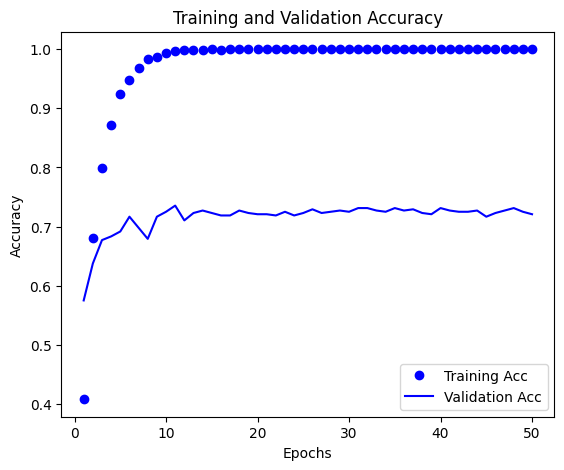

In [18]:
acc = history.history['accuracy']  # or 'acc' if using older versions of Keras/TensorFlow
val_acc = history.history['val_accuracy']  # or 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

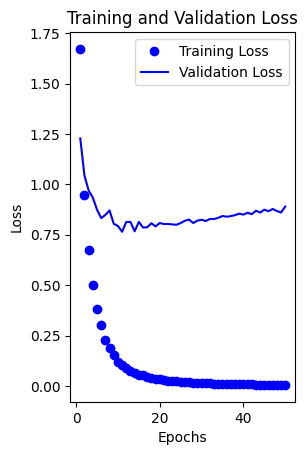

In [19]:
# Plotting training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Densenet121 with Regularization

In [64]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model for feature extraction
for layer in base_model.layers:
    layer.trainable = False



In [65]:
# Define the parameters for the data generators
img_size = (224, 224)  # DenseNet default image size
batch_size = 16

In [66]:
# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [67]:

test_datagen = ImageDataGenerator(rescale=1./255)

In [68]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 1787 images belonging to 9 classes.


In [46]:
# validation_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical')

Found 839 images belonging to 9 classes.


In [69]:
# Number of classes
num_classes = len(train_generator.class_indices)

In [70]:
# Add custom layers on top for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can change the number of units based on your specific needs
predictions = Dense(num_classes, activation='softmax')(x)  # num_classes should be set to the number of your classes



In [71]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



In [72]:
# Compile the model with a low learning rate
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])




In [73]:
# Now, after compiling, unfreeze the later layers of the base model for fine-tuning
for layer in base_model.layers[-int(len(base_model.layers) * 0.2):]:  # Unfreeze the last 20% of layers
    layer.trainable = True



In [74]:
# Re-compile the model with a very low learning rate for fine-tuning
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])



In [75]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 16,
    epochs=50,  # Set the number of epochs depending on your dataset and training time
    validation_data=0.2)
    #validation_steps=validation_generator.samples // 16)

Epoch 1/50
111/111 [==============================] - ETA: 0s - loss: 1.2464 - accuracy: 0.5878

IndexError: tuple index out of range

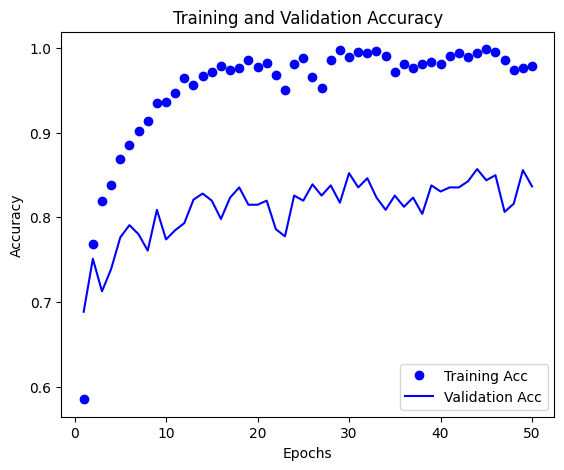

In [53]:
acc = history.history['accuracy']  # or 'acc' if using older versions of Keras/TensorFlow
val_acc = history.history['val_accuracy']  # or 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

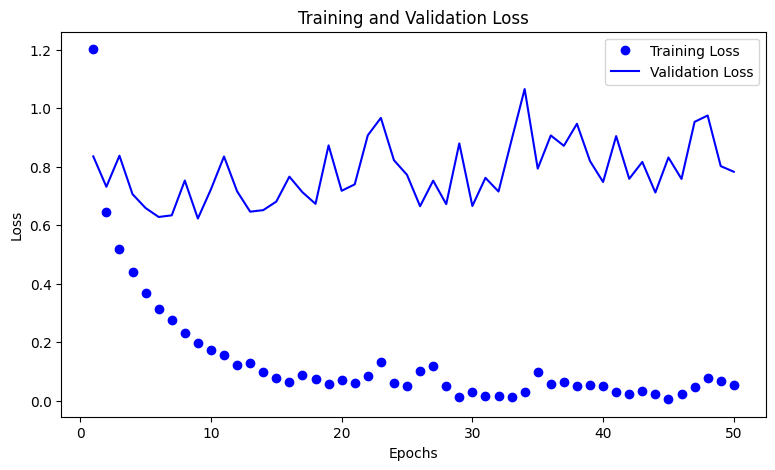

In [59]:
# Plotting training and validation loss
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluating the model

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the data generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming your test data is stored in a directory '/path/to/test'
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size for InceptionV3
    batch_size=16,  # Can be any size, depending on your system's memory
    class_mode='categorical',  # Change this if you used a different class_mode
    shuffle=False)  # Important for later mapping predictions back to labels


Found 839 images belonging to 9 classes.


In [63]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


52/52 [==============================] - 7s 137ms/step - loss: 0.7935 - accuracy: 0.8353
Test Loss: 0.7935405969619751, Test Accuracy: 0.8353365659713745


## Building an Inception V3 model

In [28]:
from tensorflow.keras.applications import InceptionV3

In [29]:
# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # InceptionV3 default input size

87910968/87910968 [==============================] - 1s 0us/step


In [30]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [31]:
# Add custom layers on top for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(9, activation='softmax')(x)

In [32]:
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [33]:
# Compile the model with the specified learning rates
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical')

Found 1787 images belonging to 9 classes.


In [37]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical')

Found 839 images belonging to 9 classes.


In [38]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,  # Ensure this fits the size of your dataset
    epochs=50,  # Adjust based on your needs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32)

Epoch 1/10
55/55 [==============================] - 72s 1s/step - loss: 1.5545 - accuracy: 0.5054 - val_loss: 0.8377 - val_accuracy: 0.6851
Epoch 2/10
55/55 [==============================] - 60s 1s/step - loss: 0.7483 - accuracy: 0.7293 - val_loss: 0.7999 - val_accuracy: 0.7103
Epoch 3/10
55/55 [==============================] - 59s 1s/step - loss: 0.6140 - accuracy: 0.7806 - val_loss: 0.7554 - val_accuracy: 0.7308
Epoch 4/10
55/55 [==============================] - 60s 1s/step - loss: 0.4590 - accuracy: 0.8393 - val_loss: 0.6041 - val_accuracy: 0.7849
Epoch 5/10
55/55 [==============================] - 59s 1s/step - loss: 0.3993 - accuracy: 0.8575 - val_loss: 0.7431 - val_accuracy: 0.7500
Epoch 6/10
55/55 [==============================] - 59s 1s/step - loss: 0.3809 - accuracy: 0.8541 - val_loss: 0.6009 - val_accuracy: 0.7981
Epoch 7/10
55/55 [==============================] - 59s 1s/step - loss: 0.3292 - accuracy: 0.8877 - val_loss: 0.6686 - val_accuracy: 0.7764
Epoch 8/10
55/55 [==

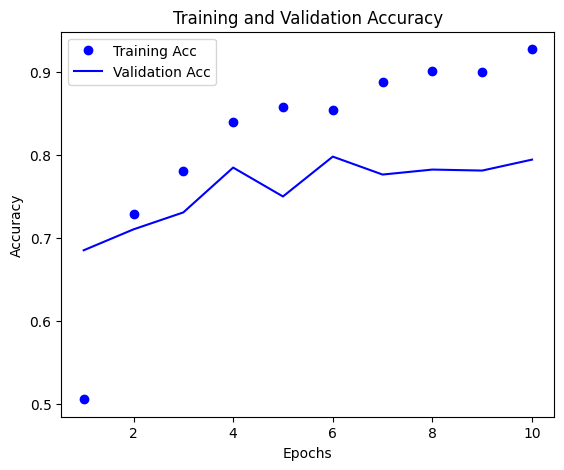

In [39]:
acc = history.history['accuracy']  # or 'acc' if using older versions of Keras/TensorFlow
val_acc = history.history['val_accuracy']  # or 'val_acc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

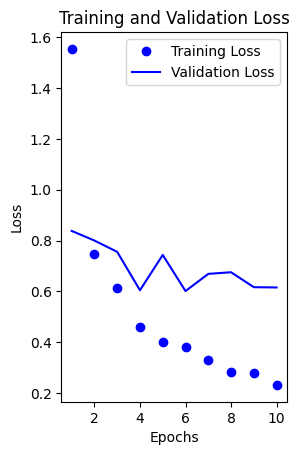

In [40]:
# Plotting training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()